In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [217]:
# constants
T = 100
N = 1000
theta = 0.1 # 100 people are L-type each round

#### Problem setup

Two lenders compete for borrowers over a period of T steps. There are a total of N borrowers in the market, where $\theta N$ are L-type borrowers who never repays, and $(1-\theta) N$ are H-type borrowers who always repays. 

In round $t-1$, suppose lender $i$ lends to $L_{i}^{t-1}$ L-type borrowers, and $H_{i}^{t-1}$ H-type borrowers, for incoming borrowers in round $t$, lender $i$ received signals as follows:
\begin{equation}
    I_i^t(H) = H,\quad  I_i^t(L) = \begin{cases}
        H, &\text{ with probability } 1- f(L_i^{t-1}, H_{i}^{t-1}),\\
        L, &\text{ with probability } f(L_i^{t-1}, H_{i}^{t-1}).
    \end{cases}
\end{equation}
where $f(\cdot, \cdot)$ is concave, differentiable, non-decreasing, with
$$
f(0,0) = 0, f(\theta N, (1-\theta) N) < 1
$$

The signals are observed independently for the two lenders.

#### Question 1

Both lenders have capacity to lend to all borrowers $N$, and their objective is a decide on an optimal interest rate to charge, based on observing the signals $H$. For simplicity, in this setting, I'm going to assume that the lender will simply deny borrowers with signal $L$. 

Challenge: how do we deal with incomplete feedback, i.e., if the lender did not offer some interest rate, the utility is not observed.

Proposed solution: use propensity scoring to approximate the utility function.

Let us assume the lenders choose from a range of interest rates $r_1 \lt r_2 \lt r_3 \dots \lt r_m$. For each offerd borrower, the utility takes three possibilities:
\begin{equation}
u(r) = \begin{cases}
r, &\text{if borrower accepts, and repays};\\
-1, &\text{if borrower accepts, and defaults};\\
0, &\text{if borrower declines}.\\
\end{cases}
\end{equation}

In each round, suppose a lender offered rates $r_1, r_2,\dots, r_m$ to $n_1, n_2, \dots,n_m$ borrowers, respectively. We will take the resulting average utility from these lenders, denoted by $u_1, u_2, \dots, u_m$, and further define the following approximate utility vector:
\begin{equation}
\bar{u}(r_j) = \begin{cases}
u_j \frac{\sum_l n_l}{n_j}, & \text{if }n_j\lt 0,\\
0, & \text{otherwise}.
\end{cases}
\end{equation}

#### Setting up the signal function

In [218]:
def f(l,h):
    return 0.99*min((l/(N*theta))**0.2, (h/(N*(1-theta)))**0.2)

In [219]:
ls, hs = np.linspace(0, N*theta, 100), np.linspace(0, N*(1-theta), 900)

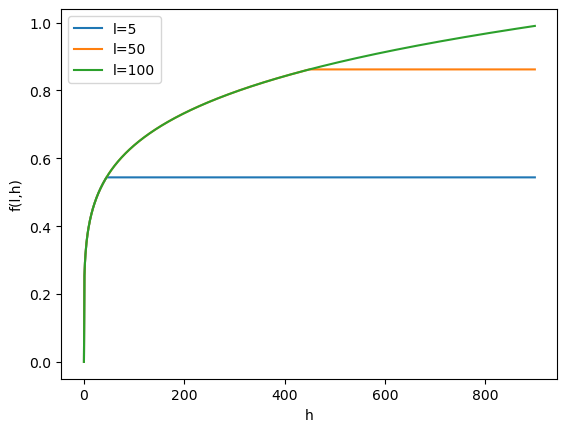

In [220]:
fs1 = [f(5, h) for h in hs]
fs2 = [f(50, h) for h in hs]
fs3 = [f(100, h) for h in hs]
plt.plot(fs1, label = 'l=5')
plt.plot(fs2, label = 'l=50')
plt.plot(fs3, label = 'l=100')
plt.xlabel('h')
plt.ylabel('f(l,h)')
plt.legend()

In [221]:
def signal_function(l, h, true_type):
    assert true_type in ['H', 'L']
    if true_type == 'H':
        return 'H'
    else:
        rand = np.random.rand()
        if rand > f(l,h):
            return 'H'
        else:
            return 'L'

In [222]:
signals = [signal_function(100, 900, 'L') for _ in range(1000)]
np.unique(signals, return_counts=True)

(array(['H', 'L'], dtype='<U1'), array([  6, 994]))

#### Suppose both lenders use follow the perturbed leader for each borrower, what is the end result?

In [223]:
# things to store
borrowers = []
borrower_choices = []
lender_offers = {
                1: [],
                2: []
    }
interest_rates = np.linspace(0.01, 0.2, 20)
lender_utilities = {
                1: np.zeros(20),
                2: np.zeros(20),
    }  # need to store these to calculate the regret, initialize to 0 utility for all choices
lender_loans = {
    1: [[0, 0]],
    2: [[0, 0]]
} # the total number of loans [l, h]-type each lender made

In [291]:
# do the simulation


for t in range(T):
    # generate borrowers
    cur_borrowers = ['H'] * int((1-theta) * N) + ['L'] * int(theta * N)

    cur_round_offers = {
        1: [],
        2: []
    }
    # for each lender
    for lender in [1,2]:
        # first generate signals
        signals = [signal_function(lender_loans[lender][-1][0], lender_loans[lender][-1][1], bor) for bor in cur_borrowers]
        for signal in signals:
            if signal == 'L':
                cur_round_offers[lender].append(100) # make no offer
            else:
                # calculate the minimum (perturbed) regret interest rate
                # note this is done for each individual borrower, otherwise all borrowers would get the same interest rate
                try:
                    regret = lender_utilities[lender].sum(axis = 0) + np.random.normal(0, 10, 20)
                    min_regret_rate = regret.argmax() # min-regret i.e. max utility
                    cur_round_offers[lender].append(interest_rates[min_regret_rate])
                except:
                    regret = np.random.normal(0, 10, 20)
                    min_regret_rate = regret.argmax()
                    cur_round_offers[lender].append(interest_rates[min_regret_rate])
        # store the offers
        lender_offers[lender].append(cur_round_offers[lender])
        
    # borrowers make decisions
    cur_borrower_choices = []
    for i in range(N):
        if cur_round_offers[1][i] == 100 and cur_round_offers[2][i] == 100:
            # neither lender made an offer
            cur_borrower_choices.append(0)
        else:
            # choose the lender with the lower interest rate
            # note that this takes into account one lender giving 100
            if cur_round_offers[1][i] < cur_round_offers[2][i]:
                cur_borrower_choices.append(1)
            elif cur_round_offers[1][i] > cur_round_offers[2][i]:
                cur_borrower_choices.append(2)
            else:
                cur_borrower_choices.append(np.random.choice([1,2]))

    # store the borrower choices
    borrower_choices.append(cur_borrower_choices)

    # reveal the true types, update utilities, update last round loans
    cur_lender_loans = {
        1: [0, 0],
        2: [0, 0],
    } # keep track of total l, h loans made by each lender this round
    cur_lender_interest_rate_offer_taken = {
        1: np.zeros(20),
        2: np.zeros(20)
    } # keep track of each lender's interest rates accepted this round
    cur_lender_utilities = {
        1: np.zeros(20),
        2: np.zeros(20)
    } # keep track of each lender's cumulative utilities for each interest rate this round
    for lender in [1,2]:
        for i in range(N):
            if cur_borrower_choices[i] == lender:
                if cur_borrowers[i] == 'L':
                    # lend to one L borrower, get -1 back
                    cur_lender_loans[lender][0] += 1
                    cur_lender_interest_rate_offer_taken[lender][interest_rates.tolist().index(cur_round_offers[lender][i])] += 1
                    cur_lender_utilities[lender][interest_rates.tolist().index(cur_round_offers[lender][i])] += (-1)
                elif cur_borrowers[i] == 'H':
                    # lend to one H borrower, get interest_rate*6 back
                    cur_lender_loans[lender][1] += 1
                    cur_lender_interest_rate_offer_taken[lender][interest_rates.tolist().index(cur_round_offers[lender][i])] += 1
                    cur_lender_utilities[lender][interest_rates.tolist().index(cur_round_offers[lender][i])] += cur_round_offers[lender][i]*6
    # update the utilities for this round
    for lender in [1,2]:
        for interest_rate_ind in range(20):
            if cur_lender_interest_rate_offer_taken[lender][interest_rate_ind] > 0:
                cur_lender_utilities[lender][interest_rate_ind] = \
                    cur_lender_utilities[lender][interest_rate_ind] * sum(cur_lender_interest_rate_offer_taken[lender]) / cur_lender_interest_rate_offer_taken[lender][interest_rate_ind] ** 2
    # append the utilities to overall
    for lender in [1,2]:
        lender_utilities[lender] = np.vstack([lender_utilities[lender], cur_lender_utilities[lender]])
        lender_loans[lender].append(cur_lender_loans[lender])

In [275]:
lender_utilities[2].sum(axis = 0) + np.random.normal(0, 10, 20)

array([ -10.38620867,    2.82640222,    6.86088532,   38.12295227,
        141.88541147,  -20.91234566,    8.38817396,   99.34972449,
         -4.66854027,  399.88491645,   38.78142959,   -8.63810424,
         22.08420989,    1.21707355,  -13.66772874,   -7.12770091,
        -14.03842156,  -27.94465191, -102.26788043, -101.50417226])

In [276]:
lender_utilities[1].sum(axis = 0) + np.random.normal(0, 10, 20)

array([-2.36106870e+01, -1.66657134e+01, -5.03842952e+00,  3.73150229e+00,
       -9.25070759e+00,  1.16472911e+01, -2.11576959e+00, -6.85400231e+00,
        1.28915324e+01, -1.61933140e+01,  5.12054594e+02, -3.35385083e-01,
        7.18202078e+00,  4.12354515e+00,  1.94326514e+00, -1.97222477e+00,
       -7.51533187e+00, -1.97547691e+01, -6.51176182e+00, -1.15010437e+02])

In [289]:
# histogram of the offers
# first filter out all the 100s
lender_offers_no100 = {
    1: [[xi for xi in x if xi!=100] for x in lender_offers[1]],
    2: [[xi for xi in x if xi!=100] for x in lender_offers[2]]
}
rounds = [1, 10, 20, 50, 93]
print('printing the offered interest rates and their counts for each lender for each round')
for r in rounds:
    print(f'round {r}')
    print('lender 1', np.unique(lender_offers_no100[1][r], return_counts=True))
    print('lender 2', np.unique(lender_offers_no100[2][r], return_counts=True))

printing the offered interest rates and their counts for each lender for each round
round 1
lender 1 (array([0.16]), array([909]))
lender 2 (array([0.2]), array([914]))
round 10
lender 1 (array([0.16]), array([918]))
lender 2 (array([0.2]), array([1000]))
round 20
lender 1 (array([0.16]), array([930]))
lender 2 (array([0.2]), array([1000]))
round 50
lender 1 (array([0.16]), array([925]))
lender 2 (array([0.2]), array([1000]))
round 93
lender 1 (array([0.16]), array([960]))
lender 2 (array([0.14]), array([901]))
